In [16]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['science', 'grid'])
matplotlib.rcParams["font.size"] = "12"

import torch
import torch.nn as nn
from torch.autograd import grad

from scipy.integrate import solve_ivp

In [17]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, hidden_layers, hidden_dim, input_dim=1, output_dim=1):
        super(FeedForwardNetwork, self).__init__()
        
        self.L = hidden_layers
        self.W = hidden_dim
        
        self.model = nn.Sequential()
        self.activation = nn.Tanh()
        
        inp_linear = nn.Linear(input_dim, hidden_dim)
        out_linear = nn.Linear(hidden_dim, output_dim)
        
        self.model.add_module('input', inp_linear)
        self.model.add_module('activ0', self.activation)
        for i in range(hidden_layers - 1):
            linear = nn.Linear(hidden_dim, hidden_dim)
            self.model.add_module(f'linear{i+1}', linear)
            self.model.add_module(f'activ{i+1}', self.activation)
        self.model.add_module('output', out_linear)
        
    def forward(self, x):
        return self.model(x)

In [18]:
def plot_solution(domain_steps, predicted_solution, numerical_solution, size=(5, 5), title=None, save=False, dpi=300):
       
    fig = plt.figure(figsize=size)
        
    plt.plot(domain_steps[:, 0], numerical_solution, label='Numerical solution')        
    plt.plot(domain_steps[:, 0], predicted_solution, label='Predicted solution')
    plt.xlabel('t')
    plt.ylabel('x(t)')
        
    plt.legend()
    plt.title(title)
    
    if save:
        plt.savefig(f'./images/oscillator/{title}.png', dpi=dpi)
            
    plt.show()

In [19]:
class DampedHarmonicOscillator:
    def __init__(self, T, params, initial_conditions):
        
        self.T = T
        self.d, self.w0 = params
        self.init_vals = torch.tensor(initial_conditions)

        self.numerical_solution = self._solve()
    
    def loss_initial(self, model):
        zero = torch.tensor([0.], requires_grad=True)
        x = model(zero)
        v = grad(x, zero, grad_outputs=torch.ones_like(x), create_graph=True)[0]
        return torch.mean(torch.square(torch.hstack([x, v]) - self.init_vals))
    
    def loss_physical(self, model, t):
        x = model(t)
        v = grad(x, t, grad_outputs=torch.ones_like(x), create_graph=True)[0]
        a = grad(v, t, grad_outputs=torch.ones_like(x), create_graph=True)[0]
        
        return torch.mean(torch.square(a + 2*self.d*self.w0 * v + self.w0**2 * x))
    
    def _solve(self):
        def harmonic_oscillator(t, y, d, w0):
            x, v = y
            dxdt = v
            dvdt = -2*d*w0 * v - w0**2 * x
            return [dxdt, dvdt]

        solution = solve_ivp(harmonic_oscillator, 
                             (0, self.T), 
                             self.init_vals, 
                             args=(self.d, self.w0), 
                             t_eval=np.linspace(0, self.T, 128))
        
        return solution.y[0]

In [20]:
def rmse(predicts, target):
    return np.sqrt(np.square(predicts - target).mean())

def train(
    problem,
    model,
    alpha, beta, N_F,
    num_iters, lr,
    print_every=1000, collect_every=1000
):
    collocation_t = torch.linspace(0, problem.T, N_F, requires_grad=True).reshape(-1, 1)
    test_points = torch.linspace(0, problem.T, 128).reshape(-1, 1)
    
    losses = []
    
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    
    for i in range(0, num_iters + 1):
        
        optim.zero_grad()
        
        L_I = problem.loss_initial(model)
        L_F = problem.loss_physical(model, collocation_t)
    
        L = alpha * L_I + beta * L_F
        
        L.backward()
        optim.step()
        
        if i % print_every == 0 and i > 0:
            predicts = model(test_points).flatten().detach().numpy()
            print(f'Iteration {i} --- Loss {L.item()} --- RMSE {rmse(predicts, problem.numerical_solution)}')
            
        if collect_every > 0 and i % collect_every == 0:
            predicts = model(test_points).flatten().detach().numpy()
            losses.append(np.array([L.item(), rmse(predicts, problem.numerical_solution)]))
    
    return np.array(losses)

In [21]:
problem = DampedHarmonicOscillator(10, (0.2, 2.0), (5.0, 7.0))
model = FeedForwardNetwork(2, 32)

alpha, beta = 1.0, 0.5
N_F = 256
num_iters, lr = 10000, 1e-3

losses = train(
    problem=problem,
    model=model,
    alpha=alpha, beta=beta, N_F=N_F,
    num_iters=num_iters, lr=lr,
    print_every=2500, collect_every=500
)

Iteration 5000 --- Loss 0.046537164598703384 --- RMSE 0.14265981743622033
Iteration 10000 --- Loss 0.006646865513175726 --- RMSE 0.04531504512048474


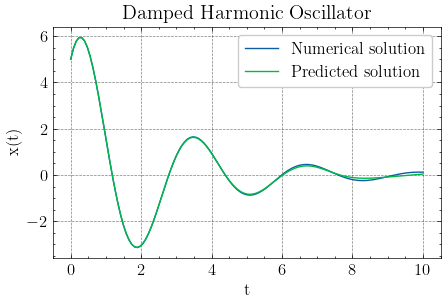

In [22]:
domain = torch.linspace(0, 10, 128).reshape(-1, 1)
predictions = model(domain).detach()
plot_solution(domain.numpy(), predictions.numpy(), problem.numerical_solution, size=(5, 3), title='Damped Harmonic Oscillator', save=True)

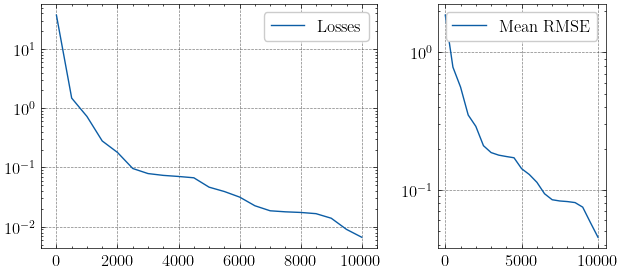

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(6.5, 3), gridspec_kw={'width_ratios': [2, 1]})

t = np.arange(0, 10000 + 1, 500)

ax[0].plot(t, losses[:,0], label=r'Losses')
ax[1].plot(t, losses[:,1], label='Mean RMSE')

ax[0].set_yscale('log')
ax[1].set_yscale('log')

# plt.grid()
ax[0].legend()
ax[1].legend()

plt.tight_layout()

plt.savefig('./images/oscillator/Losses.png', dpi=300)

plt.show()